# Test and run offline eval for comparison to ground truth values

In [82]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.morphology import skeletonize
from skimage import img_as_ubyte
from scipy.ndimage import distance_transform_edt

In [83]:
def skeleton(mask):
    skeleton = skeletonize(mask)
    return skeleton
    
def skeleton_length(mask):
    skeleton_length = np.sum(skeletonize(mask))
    return skeleton_length

def mask_area(mask):
    area = np.sum(mask)
    return area

In [84]:
# chatgpt assisted - need to debug
def get_cross_sectional_lengths(mask):
    medial_line = np.column_stack(np.where(skeletonize(mask))) # extract medial line

    directions = []
    for i in range(1, len(medial_line) - 1):
        # Get the neighboring points on the medial line to calculate direction
        p1 = medial_line[i - 1]
        p2 = medial_line[i + 1]
        
        # Direction vector (perpendicular to the line connecting p1 and p2)
        direction = np.array([p2[1] - p1[1], p1[0] - p2[0]])  # 90-degree rotation (counter-clockwise)
        direction = direction / np.linalg.norm(direction)  # Normalize direction
        directions.append(direction)
    
    cross_sections = []  # This will store the final section lengths, one for each medial point
    for i, point in enumerate(medial_line[1:-1]):
        direction = directions[i]
        
        section_length = 0
        for offset in np.linspace(-20, 20, num=100): 
            x_offset = int(round(point[0] + offset * direction[0]))  # Ensure integer pixel coordinates
            y_offset = int(round(point[1] + offset * direction[1]))  # Ensure integer pixel coordinates

            # Check if the offset point is inside the mask
            if 0 <= x_offset < mask.shape[0] and 0 <= y_offset < mask.shape[1]:  # Ensure inside bounds
                if mask[x_offset, y_offset]:  # Check if it's a body pixel
                    section_length += 1  # Count it as part of the cross-section

        cross_sections.append(section_length)  # Store the final length for this point

    return cross_sections, directions

In [85]:
# body condition cross sections
def find_intersection(mask, start_point, direction, max_distance=50):
    for dist in np.linspace(1, max_distance, num=max_distance):

        x_offset = int(round(start_point[0] + dist * direction[0]))
        y_offset = int(round(start_point[1] + dist * direction[1]))
        
        if 0 <= x_offset < mask.shape[0] and 0 <= y_offset < mask.shape[1]:
            if mask[x_offset, y_offset] == 0:  # Transition from 1 to 0; ret intersection
                return (x_offset, y_offset)
    
    return None  # Return None if no intersection 

def get_cross_sectional_points(mask, smooth_window=15):
    medial_line = np.column_stack(np.where(skeletonize(mask)))
    total_length = len(medial_line)
    cross_section_points = []

    for i in range(0, total_length, max(1, total_length // 100)): # 1% interval traversal
        point = medial_line[i]
        
        if i > smooth_window and i < total_length - smooth_window:
            p1 = medial_line[i - smooth_window]
            p2 = medial_line[i + smooth_window]
            direction = np.array([p2[1] - p1[1], p1[0] - p2[0]])  # Perpendicular direction
            direction = direction / np.linalg.norm(direction)  
        
            forward_intersection = find_intersection(mask, point, direction)
            backward_intersection = find_intersection(mask, point, -direction)
        
            if forward_intersection and backward_intersection:
                cross_section_points.append((forward_intersection, backward_intersection))

    return cross_section_points

def get_widest_cross_section(cross_section_points):
    max_distance = 0  # Initialize max distance
    widest_pair = None  # Initialize the pair with the widest cross-section

    for forward, backward in cross_section_points:
        # Calculate the Euclidean distance between the forward and backward points
        distance = np.linalg.norm(np.array(forward) - np.array(backward))

        # Update if the current distance is greater than the max distance
        if distance > max_distance:
            max_distance = distance
            widest_pair = (forward, backward)

    return widest_pair, max_distance

In [100]:
def process_biometrics(root_predictions, pred_files):
   
    data = []  # store rows for df

    for file in pred_files:
        mask_path = os.path.join(root_predictions, file) # full path 
        mask = Image.open(mask_path)
        mask = np.array(mask)

        skeleton_TL = skeleton_length(mask) # extract medial tl
        skeleton_TL_transf = skeleton_TL * (crop_size/mask_size)
        body_area = mask_area(mask) # extract body area
        cross_sectional_points = get_cross_sectional_points(mask) # extract cx points
        body_span = get_widest_cross_section(cross_sectional_points)[1] # extract max span
        body_span_transf = body_span * (crop_size/mask_size) # transf based on crop
        image_name = file.replace('pred_', '').replace('.png', '.JPG') # revert image name
        data.append((image_name, skeleton_TL, body_area, body_span, skeleton_TL_transf, body_span_transf)) # append tuple 
    
    df = pd.DataFrame(data, columns=['filename', 'skeleton_TL', 'body_area', 
                                     'body_span', 'TL_pixels_skeleton_transf', 'body_span_transf']) # construct df
        
    return(df)

In [124]:
# convert pixels to cm
def photogrammetric_conversion(df):
    gsd =  df['GSD_cm']
    flight_transf = df['Flight_Transformation'] # flight transf

    skel_pixt = df['TL_pixels_skeleton_transf'] # medial line (pix)
    body_span = df['body_span_transf']

    df['Calibrated_Skel_Length_cm'] = (skel_pixt*gsd)/flight_transf # transf w/flight-based transf
    df['Calibrated_body_span_cm'] = (body_span*gsd)/flight_transf 
 
    return df

# Import Predictions & Metadata

In [125]:
# hard coded paths 

# pixel sizes
crop_size = 512
mask_size = 224 

# predictions
root_predictions = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/split_crop/checkpoints/predictions'
pred_files = [f for f in os.listdir(root_predictions) if f.startswith("pred_")]
img_files = [f for f in os.listdir(root_predictions) if f.startswith("img_")]

# metadata
metadata = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/metadata.csv'
metadata_lengths = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/sharklengths_metadata.csv' # photog lengths


In [126]:
# make dataframes
df_meta = pd.read_csv(metadata) # metadata from exif
df_meta_len = pd.read_csv(metadata_lengths) # measurements (photogrammetry)
df_meta_len.rename(columns={'FileName': 'filename'}, inplace=True)

# merge
df_meta_full = pd.merge(df_meta_len, df_meta, on=['filename', 'White.Shark.ID'], how='left')

In [127]:
# build skeleton df
df_skel = process_biometrics(root_predictions, pred_files)

# merge skeleton with metadata
merged_df = pd.merge(df_skel, df_meta_full, on='filename', how='left')

# photogrammetric conversions
merged_df = photogrammetric_conversion(merged_df)

In [128]:
# build masks list
masks = []
for file in pred_files:
    mask_path = os.path.join(root_predictions, file)
    mask = Image.open(mask_path)
    mask = np.array(mask)
    masks.append(mask)  

# build image list
imgs = []
for file in img_files:
    img_path = os.path.join(root_predictions, file)
    img = Image.open(img_path)
    img = np.array(img)
    imgs.append(img)


Sanity check plot

In [92]:
mask = masks[7] # pull mask
skel_plot = skeleton(mask) # skeletonize mask

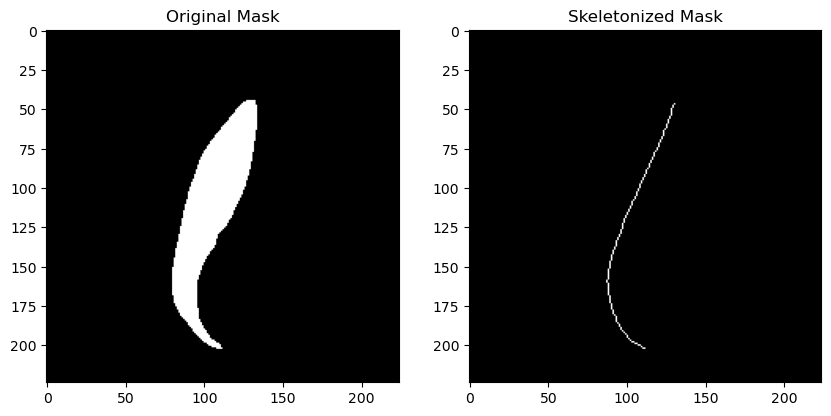

In [93]:
# Example plotting 
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Skeletonized Mask')
plt.imshow(skel_plot, cmap='gray')

plt.show()

# Plotting Pixels

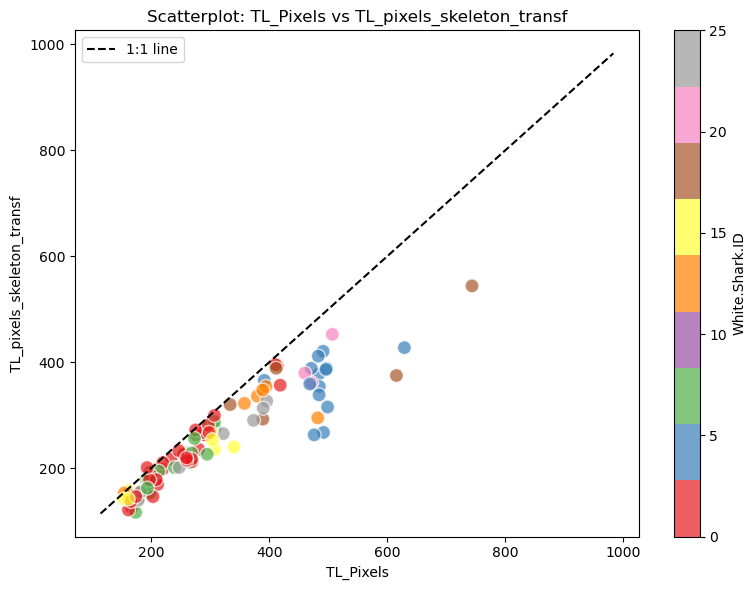

In [94]:
# Color TL:TL plot by White.Shark.ID
white_shark_id_mapping = {id_: idx for idx, id_ in enumerate(merged_df['White.Shark.ID'].unique())}
merged_df['White.Shark.ID_numeric'] = merged_df['White.Shark.ID'].map(white_shark_id_mapping)

# Create scatter plot with color mapping based on White.Shark.ID_numeric
plt.figure(figsize=(8, 6))

# Plot the scatter points, color by the numeric encoded White.Shark.ID
scatter = plt.scatter(merged_df['TL_Pixels'], merged_df['TL_pixels_skeleton_transf'],
                      c=merged_df['White.Shark.ID_numeric'], cmap='Set1', s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['TL_Pixels'].min(), merged_df['TL_pixels_skeleton_transf'].min())
max_val = max(merged_df['TL_Pixels'].max(), merged_df['TL_pixels_skeleton_transf'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('TL_Pixels')
plt.ylabel('TL_pixels_skeleton_transf')
plt.title('Scatterplot: TL_Pixels vs TL_pixels_skeleton_transf')

# Add a colorbar and legend
plt.colorbar(scatter, label='White.Shark.ID')
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


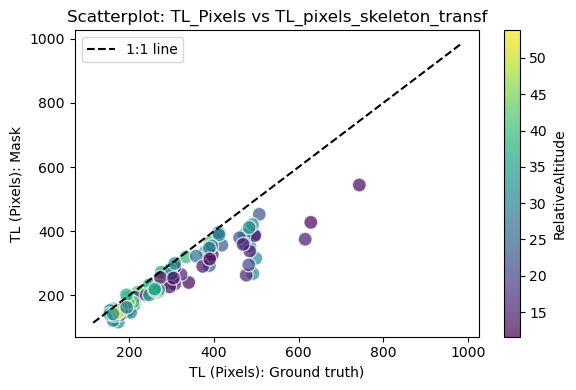

In [116]:
# Color TL:TL plot by relative altitude (cropping problem)
plt.figure(figsize=(6, 4))

# Plot the scatter points, color by 'RelativeAltitude'
scatter = plt.scatter(merged_df['TL_Pixels'], merged_df['TL_pixels_skeleton_transf'],
                      c=merged_df['RelativeAltitude_x'], cmap='viridis', s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['TL_Pixels'].min(), merged_df['TL_pixels_skeleton_transf'].min())
max_val = max(merged_df['TL_Pixels'].max(), merged_df['TL_pixels_skeleton_transf'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('TL (Pixels): Ground truth)')
plt.ylabel('TL (Pixels): Mask')
plt.title('Scatterplot: TL_Pixels vs TL_pixels_skeleton_transf')

# Add a colorbar with the label for 'RelativeAltitude'
plt.colorbar(scatter, label='RelativeAltitude')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [96]:
# compute residuals from the 1:1 line
merged_df['abs_resid'] = (merged_df['TL_Pixels'] - merged_df['TL_pixels_skeleton_transf']).abs()

# most extreme differences
top_residuals = merged_df.nlargest(10, 'abs_resid')
top_residuals

,filename,skeleton_TL,body_area,body_span,TL_pixels_skeleton_transf,Unnamed: 0,Label,TL_Pixels,White.Shark.ID,Nickname,...,RelativeAltitude_y,GimbalRollDegree,GimbalYawDegree,GimbalPitchDegree,site_y,date,Uncalibrated_Skel_Length_cm,Calibrated_Skel_Length_cm,White.Shark.ID_numeric,abs_resid
50,12132023PAMB1002.JPG,164,1176825,46.690470,374.857143,480.0,shark,615.467,MB23121302_U_9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,150.025063,NaN,19,240.609857
42,10132023PAAN0105.JPG,117,1005210,38.587563,267.428571,271.0,shark,491.940,AN23101301_M_12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,235.319549,228.346555,5,224.511429
84,10132023PAAN0104.JPG,115,994245,34.058773,262.857143,270.0,shark,476.123,AN23101301_M_12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,233.227041,226.316052,5,213.265857
115,10132023PAAN0507.JPG,187,1851045,51.078371,427.428571,287.0,shark,628.892,AN23101304_U_U,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,288.609694,299.434899,4,201.463429
149,12132023PAMB1003.JPG,238,1981095,58.000000,544.000000,481.0,shark,743.494,MB23121302_U_9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,187.894737,NaN,19,199.494000
168,10072023PAMB0306.JPG,129,1091910,40.496913,294.857143,214.0,shark,482.218,MB23100702_U_8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,165.695489,157.671033,12,187.360857
65,10132023PAAN0109.JPG,138,1054170,36.055513,315.428571,275.0,shark,498.800,AN23101301_M_12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,277.556391,269.331834,5,183.371429
90,10132023PAAN0508.JPG,148,1020255,36.221541,338.285714,288.0,shark,484.410,AN23101304_U_U,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,266.173469,276.157134,4,146.124286
26,10132023PAAN0107.JPG,155,1213800,38.183766,354.285714,273.0,shark,484.775,AN23101301_M_12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,311.748120,302.510393,5,130.489286
63,09232023PAMB0603.JPG,158,1308915,41.036569,361.142857,194.0,shark,471.884,MB23092308_F_9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,219.774436,216.022321,20,110.741143


In [113]:
def plot_mask_and_skeleton(root_predictions, filename):
    # Step 1: Construct the mask filename based on the input filename
    mask_name = "pred_" + filename.replace(".JPG", ".png")  # Assuming masks are in .png format
    
    # Step 2: Find the path to the mask using the filename
    mask_path = os.path.join(root_predictions, mask_name)
    
    # Step 3: Load the mask image
    if os.path.exists(mask_path):
        mask = Image.open(mask_path)
        mask = np.array(mask)  # Convert to numpy array
        
        # Ensure it's binary (0 for background, 1 for object)
        mask = (mask > 128).astype(int)  # If mask contains values other than 0 and 1
        
        # Step 4: Skeletonize the mask
        skeleton = skeletonize(mask)

        # Step 5: Plot the original mask and skeletonized mask side by side
        plt.figure(figsize=(7, 4))

        # Original Mask Plot
        plt.subplot(1, 2, 1)
        plt.title('Original Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')  # Hide axes for cleaner look

        # Skeletonized Mask Plot
        plt.subplot(1, 2, 2)
        plt.title('Skeletonized Mask')
        plt.imshow(skeleton, cmap='gray')
        plt.axis('off')  # Hide axes for cleaner look

        plt.tight_layout()
        plt.show()
    else:
        print(f"Mask file {mask_name} not found in {root_predictions}")

plot_mask_and_skeleton(root_predictions, filename)


NameError: name 'filename' is not defined

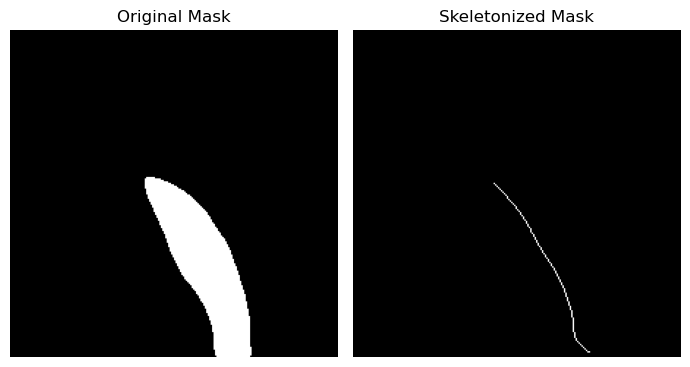

In [114]:
plot_mask_and_skeleton(root_predictions, '10132023PAAN0105.JPG')

# Photogrammetric Measurements Comparison

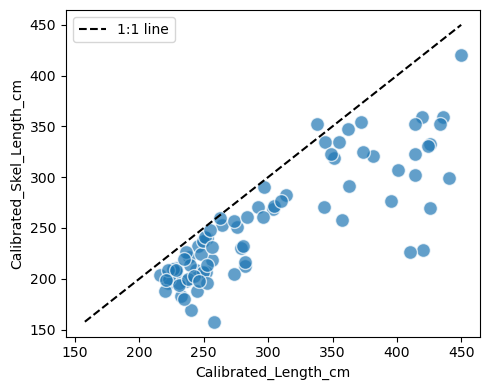

In [112]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(merged_df['Calibrated_Length_cm'], merged_df['Calibrated_Skel_Length_cm'],
                    s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['Calibrated_Length_cm'].min(), merged_df['Calibrated_Skel_Length_cm'].min())
max_val = max(merged_df['Calibrated_Length_cm'].max(), merged_df['Calibrated_Skel_Length_cm'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('Calibrated_Length_cm')
plt.ylabel('Calibrated_Skel_Length_cm')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [133]:
# comparison to visual length measurements; pull visual (ft) and convert to cm
ft_to_cm = 30.48
merged_df['VisualLength_cm'] = merged_df['White.Shark.ID'].apply(
    lambda x: float(x.split('_')[-1]) * ft_to_cm if isinstance(x, str) and x.count('_') >= 2 and x.split('_')[-1].isdigit() else None
)

In [ ]:
# Create a scatter plot with 'VisualLength_cm' vs 'Calibrated_Skel_Length_cm'
plt.figure(figsize=(8, 6))

scatter = plt.scatter(merged_df['VisualLength_cm'], merged_df['Calibrated_Skel_Length_cm'],
                      s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['VisualLength_cm'].min(), merged_df['Calibrated_Skel_Length_cm'].min())
max_val = max(merged_df['VisualLength_cm'].max(), merged_df['Calibrated_Skel_Length_cm'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('VisualLength_cm')
plt.ylabel('Calibrated_Skel_Length_cm')
plt.title('Visual Length vs Calibrated Skeleton Length')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


KeyError: 'VisualLength_cm'

<Figure size 800x600 with 0 Axes>

# Body Condition Comparisons

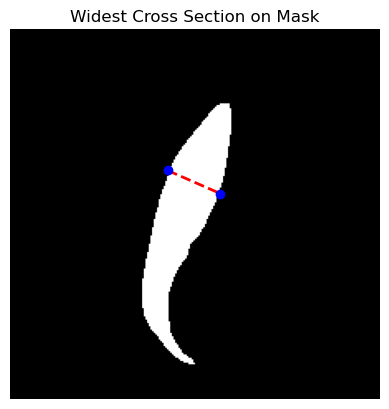

In [ ]:
mask = masks[7]

def plot_cross_sections(mask, cross_section_points):
    plt.imshow(mask, cmap='gray')
    
    for forward, backward in cross_section_points:
        plt.plot([forward[1], backward[1]], [forward[0], backward[0]], 'r-', alpha=0.5)  # Cross section line
    
    plt.title("Cross-Sectional Lines at 1% Intervals")
    plt.show()
    
def plot_widest_cross_section(mask, cross_section_points):
    # Find the widest cross section
    widest_pair, max_distance = get_widest_cross_section(cross_section_points)

    # Extract forward and backward points
    forward, backward = widest_pair

    # Plot the mask
    plt.imshow(mask, cmap='gray')
    plt.title('Widest Cross Section on Mask')
    plt.axis('off')

    # Overlay the line connecting the forward and backward points
    plt.plot([forward[1], backward[1]], [forward[0], backward[0]], color='red', linewidth=2, linestyle='--')

    # Mark the points
    plt.scatter([forward[1], backward[1]], [forward[0], backward[0]], color='blue', zorder=5)

    # Show the plot
    plt.show()

# Example usage
cross_section_points = get_cross_sectional_points(mask)
plot_widest_cross_section(mask, cross_section_points)

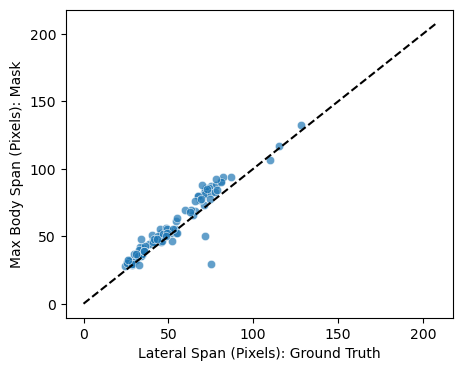

In [119]:
# Set up the plot
plt.figure(figsize=(5, 4))

# Scatter plot for spans
sns.scatterplot(data=merged_df, x='LateralSpan_Pixels', y='body_span_transf', alpha=0.7)

# Add the dashed line (x = y)
plt.plot([0, max(merged_df['LateralSpan_Pixels'].max(), merged_df['body_span_transf'].max())],
         [0, max(merged_df['LateralSpan_Pixels'].max(), merged_df['body_span_transf'].max())],
         'k--', label="x = y")  # 'k--' is the color black with a dashed line style

plt.xlabel('Lateral Span (Pixels): Ground Truth')
plt.ylabel('Max Body Span (Pixels): Mask')

# Show the plot
plt.show()

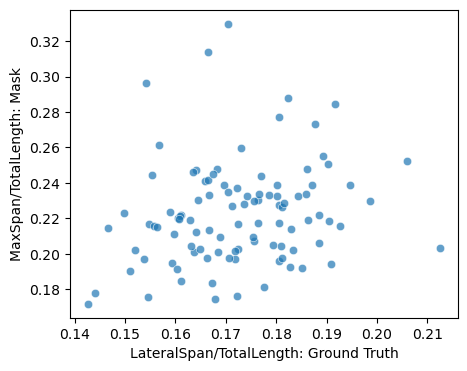

In [129]:
# why when you put it together does the relationship fall apart (???) move ratios to initial computations once debugged

# Compute BSR
merged_df['BSR'] = merged_df['body_span_transf']/merged_df['TL_pixels_skeleton_transf']

# manual BCR
merged_df['BCR'] = merged_df['FrontalSpan_Pixels']/merged_df['TL_Pixels']

# Set up the plot
plt.figure(figsize=(5, 4))

# Scatter plot for BCR vs. BAI
sns.scatterplot(data=merged_df, x='BCR', y='BSR', alpha=0.7)
plt.xlabel('LateralSpan/TotalLength: Ground Truth')
plt.ylabel('MaxSpan/TotalLength: Mask')

# Show the plot
plt.show()

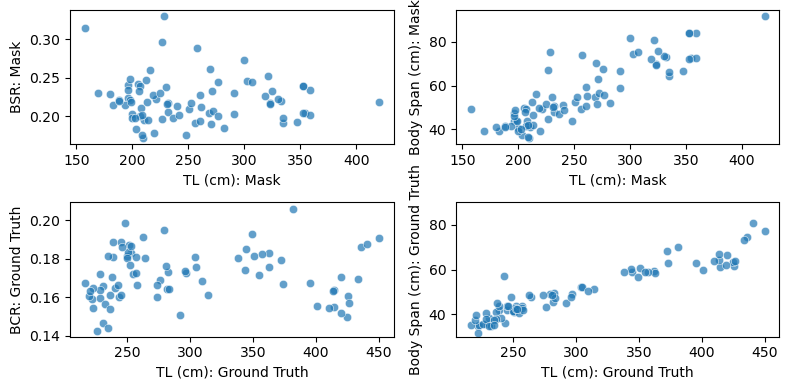

In [142]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4))

sns.scatterplot(data=merged_df, x='Calibrated_Skel_Length_cm', y='BSR', alpha=0.7, ax=axs[0,0])
axs[0,0].set_xlabel('TL (cm): Mask')
axs[0,0].set_ylabel('BSR: Mask')

sns.scatterplot(data=merged_df, x='Calibrated_Skel_Length_cm', y='Calibrated_body_span_cm', alpha=0.7, ax=axs[0,1])
axs[0,1].set_xlabel('TL (cm): Mask')
axs[0,1].set_ylabel('Body Span (cm): Mask')

sns.scatterplot(data=merged_df, x='Calibrated_Length_cm', y='BCR', alpha=0.7, ax=axs[1,0])
axs[1,0].set_xlabel('TL (cm): Ground Truth')
axs[1,0].set_ylabel('BCR: Ground Truth')

sns.scatterplot(data=merged_df, x='Calibrated_Length_cm', y='Calibrated_LS_cm', alpha=0.7, ax=axs[1,1])
axs[1,1].set_xlabel('TL (cm): Ground Truth')
axs[1,1].set_ylabel('Body Span (cm): Ground Truth')
plt.ylim(30,90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

